# Generative Adversarial Network for ECG synthesis


![](https://64.media.tumblr.com/66dc00e688f72af4d7b5d768005359c4/094fefb7e60b17ee-9c/s500x750/3060385c5fdcb38f3a716d8a309a40e69e598a5f.png)

## Import Necessary libraries

In [3]:
import os
import time

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam


In [8]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Config()
seed_everything(config.seed)

In [3]:
df_ptbdb = pd.read_csv('../input/heartbeat/ptbdb_abnormal.csv')
df_mitbih = pd.read_csv('../input/heartbeat/mitbih_train.csv')
df_ptbdb.head(5)


,9.322328567504882812e-01,8.696785569190979004e-01,8.861859440803527832e-01,9.296264052391052246e-01,9.087749719619750977e-01,9.339704513549804688e-01,8.010425567626953125e-01,7.497828006744384766e-01,6.872285008430480957e-01,6.350998878479003906e-01,...,0.000000000000000000e+00.117,0.000000000000000000e+00.118,0.000000000000000000e+00.119,0.000000000000000000e+00.120,0.000000000000000000e+00.121,0.000000000000000000e+00.122,0.000000000000000000e+00.123,0.000000000000000000e+00.124,0.000000000000000000e+00.125,1.000000000000000000e+00.1
0,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.925265,0.433352,0.073620,0.079197,0.136643,0.182934,0.182934,0.182376,0.196877,0.203569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Labeling of the ECG signals

In [4]:
df_mitbih_train = pd.read_csv('../input/heartbeat/mitbih_train.csv', header=None)
df_mitbih_test = pd.read_csv('../input/heartbeat/mitbih_test.csv', header=None)
df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'class'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)
print(df_mitbih.info())



<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 189 entries, 0 to label
dtypes: float64(188), object(1)
memory usage: 158.7+ MB
None


In [5]:
df_sample = df_mitbih

In [ ]:
df_mitbih.to_csv('data.csv', index=False)
config.csv_path = '/kaggle/input/input-csv/data.csv'

In [9]:
config.csv_path = '/kaggle/input/input-csv/data.csv'

In [ ]:
df_sample.info()

In [ ]:
df_mitbih_train.to_csv('data_train.csv', index=False)
df_mitbih_test.to_csv('data_test.csv', index=False )

# Basic EDA

In [7]:
df_mitbih['label'].value_counts()

Normal                               90589
Fusion of paced and normal            8039
Premature ventricular contraction     7236
Artial Premature                      2779
Fusion of ventricular and normal       803
Name: label, dtype: int64

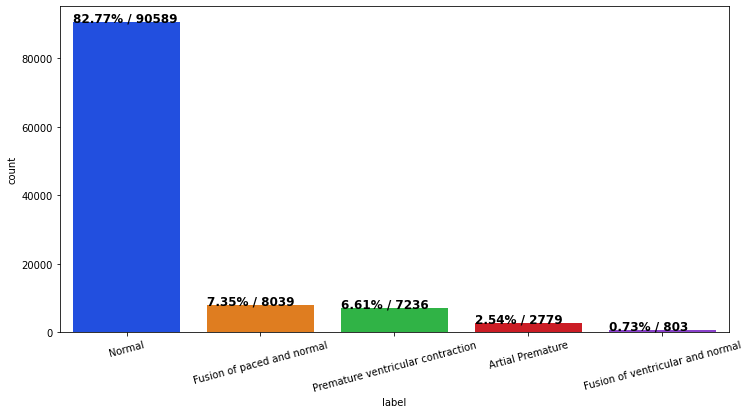

In [70]:
percentages = [count / df_mitbih.shape[0] * 100 for count in df_mitbih['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_mitbih['label'],
    ax=ax,
    palette="bright",
    order=df_mitbih['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_mitbih['label'].value_counts(sort=True).values,
    ax.patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')
    
plt.savefig('data_dist.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

# Dataset

In [10]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])                 
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader
    
    
# dataloader = get_dataloader(label_name='Artial Premature', batch_size=96)

# print(len(dataloader))
# x,y = next(iter(dataloader))
# x.shape, y.shape

## Discriminator and Generator Models

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 187)
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=128,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1,256)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        return x.unsqueeze(1)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.rnn_layer = nn.LSTM(
                input_size=187,
                hidden_size=256,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = torch.sigmoid(self.fc3(x))
        return x

# Training stage

In [12]:
class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        batch_size,
        num_epochs,
        label
    ):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.netG = generator.to(self.device)
        self.netD = discriminator.to(self.device)
        
        self.optimizerD = Adam(self.netD.parameters(), lr=0.0002)
        self.optimizerG = Adam(self.netG.parameters(), lr=0.0002)
        self.criterion = nn.BCELoss()
        
        self.batch_size = batch_size
        self.signal_dim = [self.batch_size, 1, 187]
        self.num_epochs = num_epochs
        self.dataloader = get_dataloader(
            label_name=label, batch_size=self.batch_size
        )
        self.fixed_noise = torch.randn(self.batch_size, 1, 187,
                                       device=self.device)
        self.g_errors = []
        self.d_errors = []
        
    def _one_epoch(self):
        real_label = 1
        fake_label = 0
        
        for i, data in enumerate(self.dataloader, 0):
            ##### Update Discriminator: maximize log(D(x)) + log(1 - D(G(z))) #####
            ## train with real data
            self.netD.zero_grad()
            real_data = data[0].to(self.device)
            # dim for noise
            batch_size = real_data.size(0)
            self.signal_dim[0] = batch_size
            
            label = torch.full((batch_size,), real_label,
                           dtype=real_data.dtype, device=self.device)
            
            output = self.netD(real_data)
            output = output.view(-1)
       
            errD_real = self.criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            
            ## train with fake data
            noise = torch.randn(self.signal_dim, device=self.device)
            fake = self.netG(noise)
            label.fill_(fake_label)
            
            output = self.netD(fake.detach())
            output = output.view(-1)
            
            errD_fake = self.criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake 
            self.optimizerD.step()
            
            ##### Update Generator: maximaze log(D(G(z)))  
            self.netG.zero_grad()
            label.fill_(real_label) 
            output = self.netD(fake)
            output = output.view(-1)
            
            errG = self.criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            self.optimizerG.step()
            
        return errD.item(), errG.item()
        
    def run(self):
        for epoch in range(self.num_epochs):
            errD_, errG_ = self._one_epoch()
            self.d_errors.append(errD_)
            self.g_errors.append(errG_)
            if epoch % 300 == 0:
                print(f"Epoch: {epoch} | Loss_D: {errD_} | Loss_G: {errG_} | Time: {time.strftime('%H:%M:%S')}")
   
                fake = self.netG(self.fixed_noise)
                plt.plot(fake.detach().cpu().squeeze(1).numpy()[:].transpose())
                plt.show()
            
        torch.save(self.netG.state_dict(), f"generator.pth")
        torch.save(self.netG.state_dict(), f"discriminator.pth")

In [13]:
g = Generator()
d = Discriminator()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:207.)
  if __name__ == "__main__":


Epoch: 0 | Loss_D: 1.3506883382797241 | Loss_G: 0.6978179812431335 | Time: 09:53:01


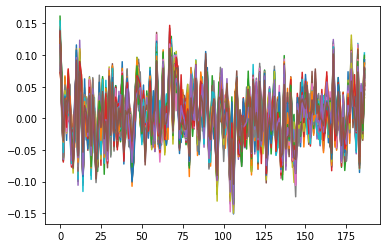

Epoch: 300 | Loss_D: 0.3605041801929474 | Loss_G: 2.7661006450653076 | Time: 09:58:05


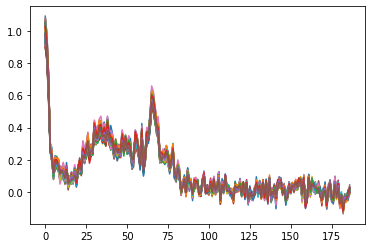

Epoch: 600 | Loss_D: 0.43702784180641174 | Loss_G: 1.84048330783844 | Time: 10:03:13


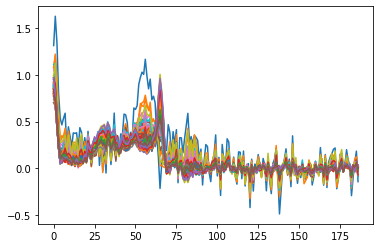

Epoch: 900 | Loss_D: 0.420891135931015 | Loss_G: 2.1025514602661133 | Time: 10:08:18


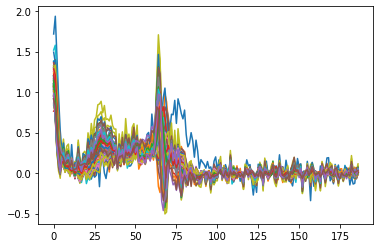

Epoch: 1200 | Loss_D: 0.7052779197692871 | Loss_G: 2.177982807159424 | Time: 10:13:22


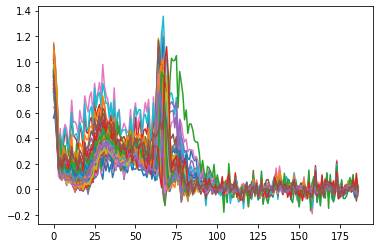

Duration: 0:25:40.212212


In [14]:
from datetime import datetime
start_time = datetime.now()

trainer = Trainer(
    generator=g,
    discriminator=d,
    batch_size=96,
    num_epochs=1500,
    label='Fusion of ventricular and normal'
)
trainer.run()
end_time = datetime.now()
duration = end_time - start_time
print("Duration:", duration)

Epoch: 0 | Loss_D: 0.776543915271759 | Loss_G: 2.526076316833496 | Time: 07:26:31


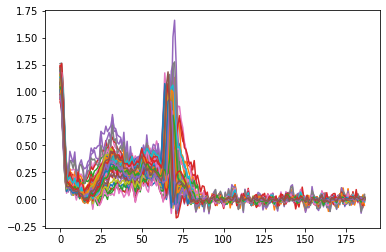

Epoch: 300 | Loss_D: 0.320616751909256 | Loss_G: 3.334343910217285 | Time: 07:44:02


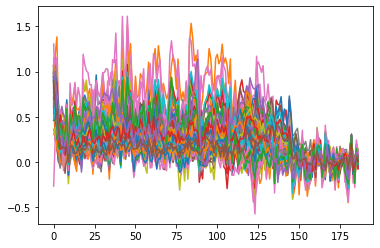

Epoch: 600 | Loss_D: 0.24842581152915955 | Loss_G: 3.575143337249756 | Time: 08:01:36


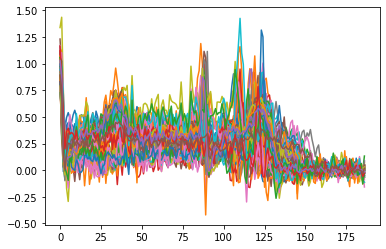

Epoch: 900 | Loss_D: 0.4390062093734741 | Loss_G: 3.178781747817993 | Time: 08:19:03


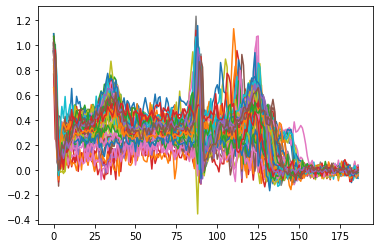

Epoch: 1200 | Loss_D: 0.12284082174301147 | Loss_G: 3.233218193054199 | Time: 08:36:47


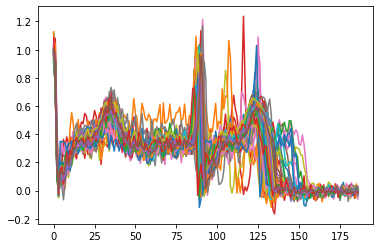

In [ ]:
from datetime import datetime
start_time = datetime.now()

trainer1 = Trainer(
    generator=g,
    discriminator=d,
    batch_size=96,
    num_epochs=1500,
    label="Artial Premature"
)
trainer1.run()
end_time = datetime.now()
duration = end_time - start_time
print("Duration:", duration)


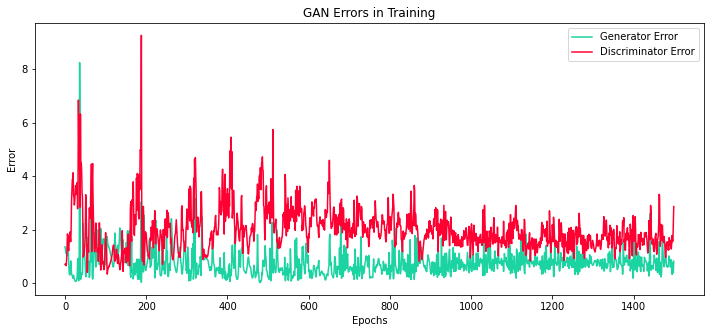

In [15]:
plt.figure(figsize=(12, 5))
plt.title("GAN Errors in Training")
plt.plot(trainer.d_errors, label='Generator Error', c='#1CD3A2')
plt.plot(trainer.g_errors, label='Discriminator Error', c='#FF0033')
plt.xlabel("Epochs")
plt.ylabel('Error')
_ = plt.legend()
plt.savefig('Gan_Losses.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

# Conclusion
Since this is a standard process for training a GAN model, we can observe that the Generator produces predominantly dominant signal types.
More specifically, we have a total of 803 signals of the '"Fusion of ventricular and normal"' class, most of which are very similar, and that's what GAN model learned to generate.

In [ ]:
df_mitbih['label'].value_counts()

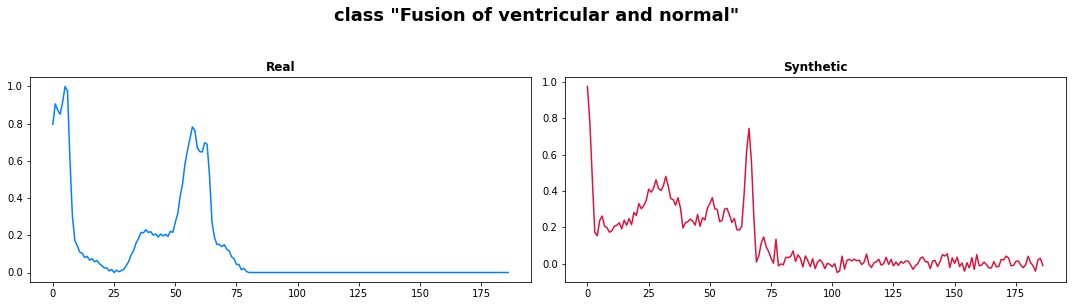

In [16]:
df = pd.read_csv(config.csv_path)
df = df.loc[df['label'] == 'Fusion of ventricular and normal']

# real signal
N = 1
real_samples =  df.sample(N).values[:, :-2].transpose()
# real_samples1 = df.sample(N)
# print(real_samples1)

# synthetic signal
fake = trainer.netG(trainer.fixed_noise)
index = np.random.choice(fake.shape[0], N, replace=False) 
# synthetic_samples1 = fake.detach().cpu().squeeze(1).numpy()[index]
synthetic_samples = fake.detach().cpu().squeeze(1).numpy()[index].transpose()
# print(synthetic_samples1)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))


axs[0].plot(real_samples, c='#007FFF')
axs[0].set_title("Real", fontsize= 12, weight="bold")


axs[1].plot(synthetic_samples, c="crimson")
axs[1].set_title("Synthetic", fontsize= 12, weight="bold")

plt.suptitle('class "Fusion of ventricular and normal"', fontsize=18, y=1.05, weight="bold")
plt.tight_layout()
plt.savefig('Fusion_of_ventricular_and_normal.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [ ]:
# 3, 'Fusion of ventricular and normal'
col_values = [[3, 'Fusion of ventricular and normal']]
for i in range(1, 1000):
    fake = trainer.netG(trainer.fixed_noise)
    index = np.random.choice(fake.shape[0], 1, replace=False) 
    synthetic_samples1 = fake.detach().cpu().squeeze(1).numpy()[index]
    new_array = np.append(synthetic_samples1, col_values, axis=1)
    new_row = pd.DataFrame(new_array, columns=df_sample.columns)
    df_sample = df_sample.append(new_row, ignore_index=True) 


In [ ]:
#  1: "Artial Premature",
col_values = [[1, "Artial Premature"]]
for i in range(1, 1800):
    fake = trainer1.netG(trainer1.fixed_noise)
    index = np.random.choice(fake.shape[0], 1, replace=False) 
    synthetic_samples1 = fake.detach().cpu().squeeze(1).numpy()[index]
    new_array = np.append(synthetic_samples1, col_values, axis=1)
    new_row = pd.DataFrame(new_array, columns=df_sample.columns)
    df_sample = df_sample.append(new_row, ignore_index=True) 

In [ ]:
df_sample.tail()
# df_mitbih_train

In [17]:
# 109446
# 109647

df_sample = pd.read_csv('/kaggle/input/data-synthetic/data_with_synthetic_content1.csv')

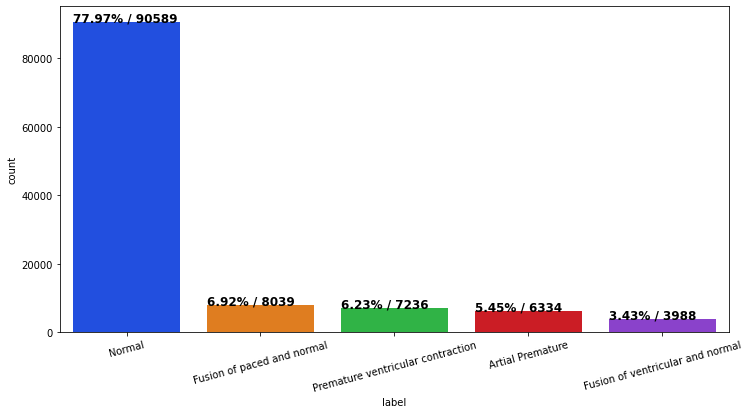

In [18]:
percentages = [count / df_sample.shape[0] * 100 for count in df_sample['label'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=df_sample['label'],
    ax=ax,
    palette="bright",
    order=df_sample['label'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
    percentages,
    df_sample['label'].value_counts(sort=True).values,
    ax.patches):
    
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage)+" / "+str(count), (x, y), fontsize=12, fontweight='bold')
    
plt.savefig('data_dist_after_gan.png', facecolor='w', edgecolor='w', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)


In [ ]:
df_sample.to_csv('data_with_synthetic_content1.csv', index=False)

In [2]:
import random
import torch

In [ ]:
data = pd.read_csv('data_with_synthetic_content1.csv')
data.info()

In [4]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    cnn_state_path = '../input/mitbih-with-synthetic/cnn.pth'
    cnn_logs = '../input/mitbih-with-synthetic/cnn.csv'
    
    train_csv_path = '../input/mitbih-with-synthetic/mitbih_with_syntetic_train.csv'
    test_csv_path = '../input/mitbih-with-synthetic/mitbih_with_syntetic_test.csv'

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
config = Config()
seed_everything(config.seed)

In [5]:
config.csv_path = "kaggle.com/datasets/hasankumar/data_synthetic/data_with_synthetic_content1.csv"


In [6]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()

    def __getitem__(self, idx):
        signal = self.df.loc[idx, self.data_columns].astype('float32')
        signal = torch.FloatTensor([signal.values])                 
        target = torch.LongTensor(np.array(self.df.loc[idx, 'class']))
        return signal, target

    def __len__(self):
        return len(self.df)

In [7]:
def get_dataloader(phase: str, batch_size: int = 96) -> DataLoader:
    '''
    Dataset and DataLoader.
    Parameters:
        pahse: training or validation phase.
        batch_size: data per iteration.
    Returns:
        data generator
    '''
    df = pd.read_csv(config.train_csv_path)
    train_df, val_df = train_test_split(
        df, test_size=0.15, random_state=config.seed, stratify=df['label']
    )
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4)
    return dataloader

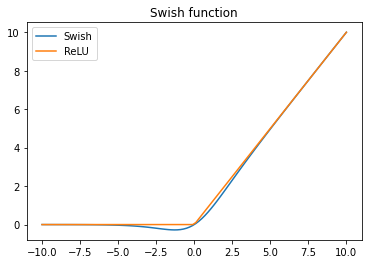

In [8]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
x = torch.linspace(-10.0, 10.0, 100)
swish = Swish()
swish_out = swish(x)
relu_out = torch.relu(x)

plt.title('Swish function')
plt.plot(x.numpy(), swish_out.numpy(), label='Swish')
plt.plot(x.numpy(), relu_out.numpy(), label='ReLU')
plt.legend();
plt.show()

In [9]:
class ConvNormPool(nn.Module):
    """Conv Skip-connection module"""
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)
            
        self.pool = nn.MaxPool1d(kernel_size=2)
        
    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))
        
        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))
        
        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))   
        
        x = self.pool(x)
        return x

In [10]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size = 1,
        hid_size = 256,
        kernel_size = 5,
        num_classes = 5,
    ):
        
        super().__init__()
        
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size//2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size//2,
            hidden_size=hid_size//4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size//4, out_features=num_classes)
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)        
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        x = F.softmax(self.fc(x), dim=1)
        return x

In [11]:
class Meter:
    def __init__(self, n_classes=5):
        self.metrics = {}
        self.confusion = torch.zeros((n_classes, n_classes))
    
    def update(self, x, y, loss):
        x = np.argmax(x.detach().cpu().numpy(), axis=1)
        y = y.detach().cpu().numpy()
        self.metrics['loss'] += loss
        self.metrics['accuracy'] += accuracy_score(x,y)
        self.metrics['f1'] += f1_score(x,y,average='macro')
        self.metrics['precision'] += precision_score(x, y, average='macro', zero_division=1)
        self.metrics['recall'] += recall_score(x,y, average='macro', zero_division=1)
        
        self._compute_cm(x, y)
        
    def _compute_cm(self, x, y):
        for prob, target in zip(x, y):
            if prob == target:
                self.confusion[target][target] += 1
            else:
                self.confusion[target][prob] += 1
    
    def init_metrics(self):
        self.metrics['loss'] = 0
        self.metrics['accuracy'] = 0
        self.metrics['f1'] = 0
        self.metrics['precision'] = 0
        self.metrics['recall'] = 0
        
    def get_metrics(self):
        return self.metrics
    
    def get_confusion_matrix(self):
        return self.confusion

In [12]:
class Trainer:
    def __init__(self, net, lr, batch_size, num_epochs):
        self.net = net.to(config.device)
        self.num_epochs = num_epochs
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(self.net.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
        self.best_loss = float('inf')
        self.phases = ['train', 'val']
        self.dataloaders = {
            phase: get_dataloader(phase, batch_size) for phase in self.phases
        }
        self.train_df_logs = pd.DataFrame()
        self.val_df_logs = pd.DataFrame()
    
    def _train_epoch(self, phase):
        print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")
        
        self.net.train() if phase == 'train' else self.net.eval()
        meter = Meter()
        meter.init_metrics()
        
        for i, (data, target) in enumerate(self.dataloaders[phase]):
            data = data.to(config.device)
            target = target.to(config.device)
            
            output = self.net(data)
            loss = self.criterion(output, target)
                        
            if phase == 'train':
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
            meter.update(output, target, loss.item())
        
        metrics = meter.get_metrics()
        metrics = {k:v / i for k, v in metrics.items()}
        df_logs = pd.DataFrame([metrics])
        confusion_matrix = meter.get_confusion_matrix()
        
        if phase == 'train':
            self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
        else:
            self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)
        
        # show logs
        print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
              .format(*(x for kv in metrics.items() for x in kv))
             )
        fig, ax = plt.subplots(figsize=(5, 5))
        cm_ = ax.imshow(confusion_matrix, cmap='hot')
        ax.set_title('Confusion matrix', fontsize=15)
        ax.set_xlabel('Actual', fontsize=13)
        ax.set_ylabel('Predicted', fontsize=13)
        plt.colorbar(cm_)
        plt.show()
        
        return loss
    
    def run(self):
        for epoch in range(self.num_epochs):
            self._train_epoch(phase='train')
            with torch.no_grad():
                val_loss = self._train_epoch(phase='val')
                self.scheduler.step()
            
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                print('\nNew checkpoint\n')
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")

In [13]:
model = CNN(hid_size=128)


In [14]:
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

train mode | time: 05:39:49
loss: 1.0059238997880906, accuracy: 0.9301569174381151, f1: 0.7409664190180768, precision: 0.7326507068727954, recall: 0.9140775563549819


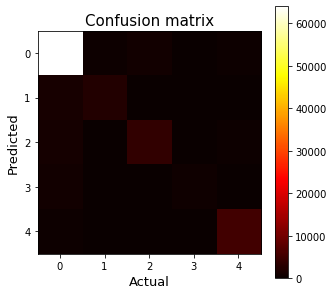

val mode | time: 05:41:18
loss: 0.9530848769346872, accuracy: 0.9683552631578948, f1: 0.876576867020704, precision: 0.8513751688835475, recall: 0.9712155469871825


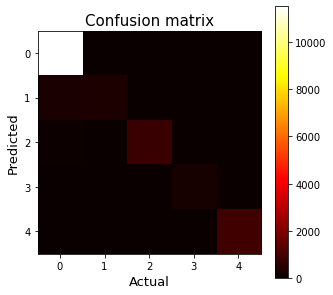


New checkpoint

train mode | time: 05:41:31
loss: 0.9385513795358494, accuracy: 0.9711030878171695, f1: 0.9019017382815206, precision: 0.8879046655076229, recall: 0.9573096690019555


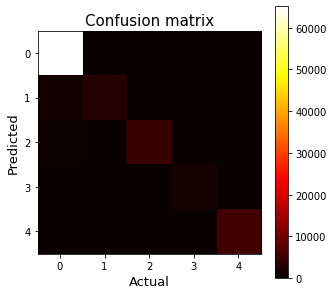

val mode | time: 05:42:50
loss: 0.9419262715180715, accuracy: 0.9770138888888887, f1: 0.9168224726712126, precision: 0.8998510212301577, recall: 0.9710454302736675


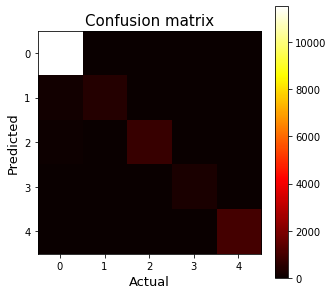


New checkpoint

train mode | time: 05:43:03
loss: 0.9311265804982828, accuracy: 0.9777340960235018, f1: 0.9229644072698323, precision: 0.9107036205550514, recall: 0.9685918118131025


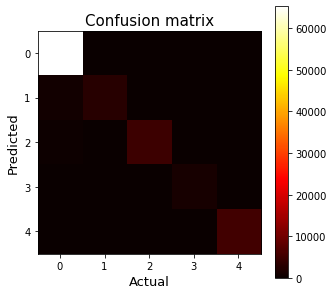

val mode | time: 05:44:21
loss: 0.9355855989456177, accuracy: 0.9836111111111111, f1: 0.9383190686150131, precision: 0.9260780347704908, recall: 0.9743094196729186


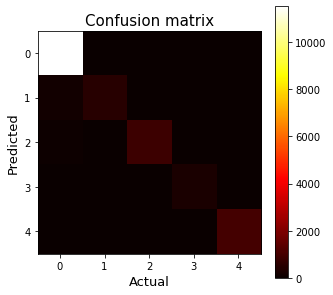

train mode | time: 05:44:35
loss: 0.9274462614501068, accuracy: 0.980616081173951, f1: 0.9310061254452012, precision: 0.9172737202503535, recall: 0.9757291382546


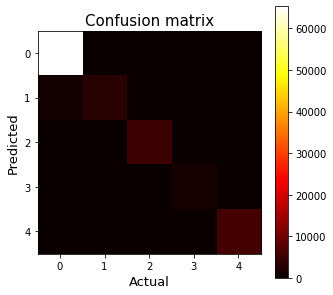

val mode | time: 05:45:53
loss: 0.9330099519093832, accuracy: 0.9853472222222227, f1: 0.9388029530143289, precision: 0.9261220539486732, recall: 0.9786687085097462


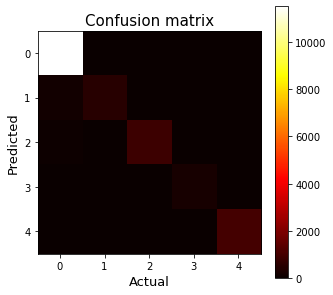

train mode | time: 05:46:07
loss: 0.9245603336818333, accuracy: 0.9832782538976715, f1: 0.9378093235234477, precision: 0.9253103774454638, recall: 0.9799564032662936


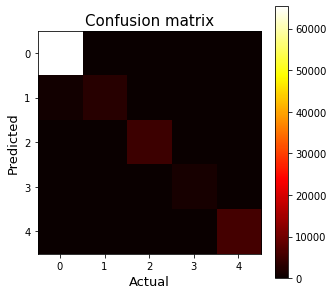

val mode | time: 05:47:25
loss: 0.9342420454819997, accuracy: 0.9838888888888897, f1: 0.9342152493969506, precision: 0.9183541879990397, recall: 0.9777629623358344


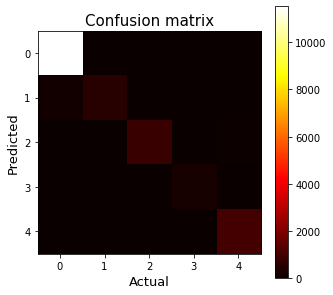


New checkpoint

train mode | time: 05:47:39
loss: 0.9231117995235314, accuracy: 0.9845604930535918, f1: 0.9416357073603846, precision: 0.9279098174169648, recall: 0.9830037581018134


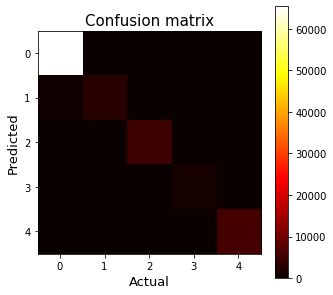

val mode | time: 05:48:57
loss: 0.9310547196865082, accuracy: 0.9870138888888893, f1: 0.9430148225649206, precision: 0.9272319340488872, recall: 0.9848297821949729


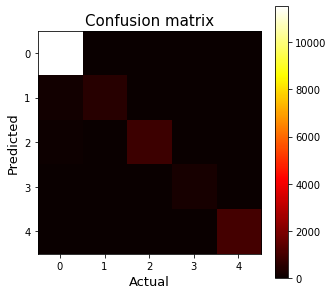


New checkpoint

train mode | time: 05:49:11
loss: 0.9218579740345408, accuracy: 0.9855778624462685, f1: 0.9447465073527472, precision: 0.9326263992588528, recall: 0.9835662333184009


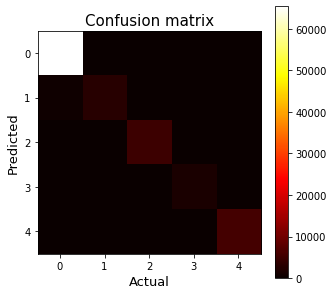

val mode | time: 05:50:29
loss: 0.9302076649665832, accuracy: 0.9877083333333339, f1: 0.9461876932274725, precision: 0.9358465331138416, recall: 0.9792954861663388


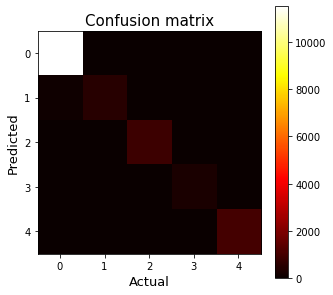


New checkpoint

train mode | time: 05:50:43
loss: 0.9207766408937058, accuracy: 0.9866525009769459, f1: 0.9484952505357658, precision: 0.9358270306126801, recall: 0.986007320009381


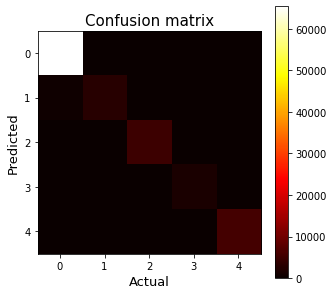

val mode | time: 05:52:01
loss: 0.9290642078717549, accuracy: 0.9884722222222225, f1: 0.9498481351080875, precision: 0.9369187143734699, recall: 0.9853304099175286


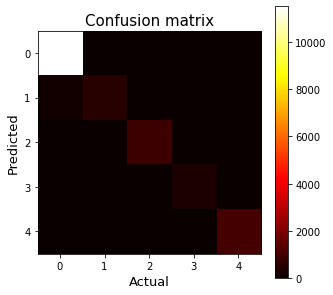

train mode | time: 05:52:14
loss: 0.919967767432035, accuracy: 0.9873729972645579, f1: 0.9501215414164774, precision: 0.938028174486083, recall: 0.9866793029813399


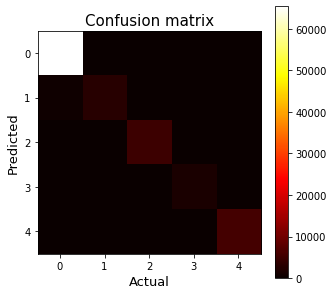

val mode | time: 05:53:34
loss: 0.9279563295841217, accuracy: 0.9896527777777783, f1: 0.9525595417209632, precision: 0.9380070344062066, recall: 0.9891599202041957


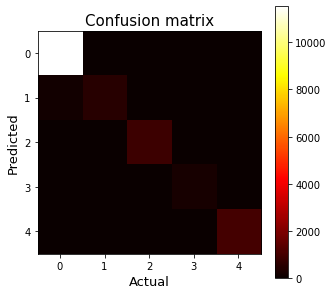


New checkpoint

train mode | time: 05:53:47
loss: 0.9193943822090399, accuracy: 0.987824833919501, f1: 0.9514137655762793, precision: 0.939105150463048, recall: 0.9879000072598545


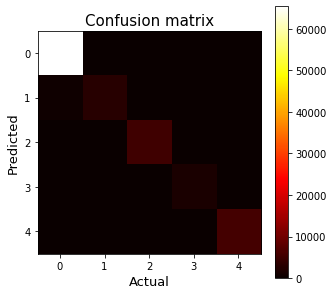

val mode | time: 05:55:05
loss: 0.9278407247861227, accuracy: 0.9898611111111114, f1: 0.9519769257354508, precision: 0.938744461756058, recall: 0.9860016245287041


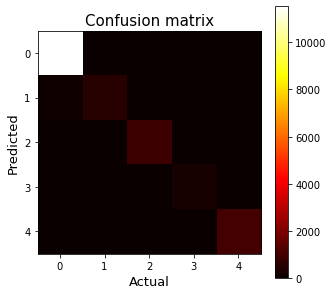

Duration: 0:15:40.514966


In [15]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
start_time = datetime.now()
trainer3 = Trainer(net=model, lr=1e-3, batch_size=96, num_epochs=10)#100)
trainer3.run()
end_time = datetime.now()
duration = end_time - start_time
print("Duration:", duration)


In [16]:
cnn_model = CNN(hid_size=128).to(config.device)
cnn_model.load_state_dict(
    torch.load(config.cnn_state_path,
               map_location=config.device)
);
cnn_model.eval();
logs = pd.read_csv(config.cnn_logs)

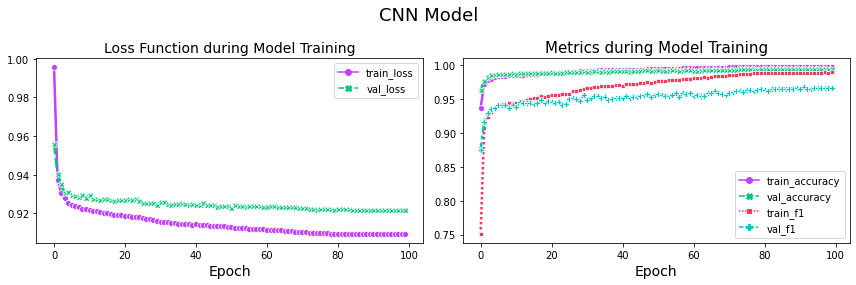

In [17]:
colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
palettes = [sns.color_palette(colors, 2),
            sns.color_palette(colors, 4), 
            sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]
            
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(data=logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
ax[0].set_title("Loss Function during Model Training", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)

sns.lineplot(data=logs.iloc[:, 2:6], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
ax[1].set_title("Metrics during Model Training", fontsize=15)
ax[1].set_xlabel("Epoch", fontsize=14)

plt.suptitle('CNN Model', fontsize=18)

plt.tight_layout()
fig.savefig("cnn.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("cnn.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [18]:
test_df = pd.read_csv(config.test_csv_path)
print(test_df.shape)
test_dataset = ECGDataset(test_df)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=96, num_workers=0, shuffle=False)

(17008, 189)


In [19]:
def make_test_stage(dataloader, model, probs=False):
    cls_predictions = []
    cls_ground_truths = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():

            data = data.to(config.device)
            cls_target = cls_target.cpu()
            cls_prediction = model(data)
            
            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)
    
            cls_predictions.append(cls_prediction.detach().cpu())
            cls_ground_truths.append(cls_target)

    predictions_cls = torch.cat(cls_predictions).numpy()
    ground_truths_cls = torch.cat(cls_ground_truths).numpy()
    return predictions_cls, ground_truths_cls, cls_predictions, cls_ground_truths

In [20]:
y_pred, y_true = make_test_stage(test_dataloader, cnn_model)
y_pred.shape, y_true.shape

((17008,), (17008,))

In [27]:

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}

In [28]:
report = pd.DataFrame(
    classification_report(
        y_pred,
        y_true,
        output_dict=True
    )
).transpose()

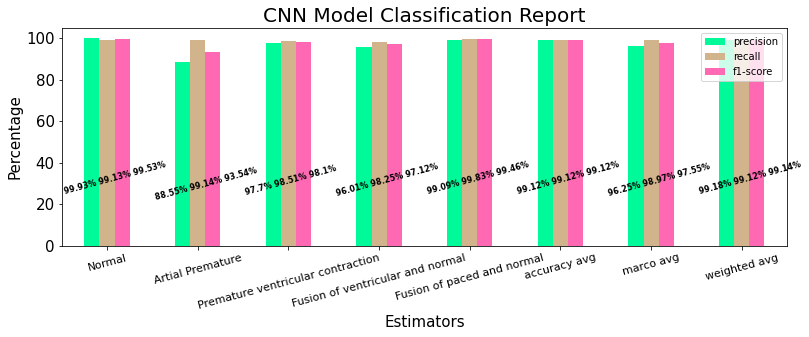

In [29]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(id_to_label.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
fig.savefig("cnn_report.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
plt.show()

In [30]:
def prediction(dataloader, model, probs=False):
    cls_predictions = []

    for i, (data, cls_target) in enumerate(dataloader):
        with torch.no_grad():

            data = data.to(config.device)
            cls_prediction = model(data)
            
            if not probs:
                cls_prediction = torch.argmax(cls_prediction, dim=1)
    
            cls_predictions.append(cls_prediction.detach().cpu())

    predictions_cls = torch.cat(cls_predictions).numpy()
    return predictions_cls

In [32]:

data = pd.read_csv('/kaggle/input/mitbih-with-synthetic/mitbih_with_syntetic_test.csv')
real_samples =  data.tail(1)

In [33]:
selected_row = data.iloc[5]
new_df = pd.DataFrame([selected_row]).reset_index(drop=True)


In [34]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,class,label
0,1.0,0.94075,0.741233,0.475212,0.255139,0.187424,0.183797,0.153567,0.128174,0.114873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,Premature ventricular contraction


In [45]:
real_samples.head()

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,class,label
17007,1.0,0.88664,0.368421,0.072874,0.0,0.093117,0.064777,0.060729,0.036437,0.052632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


In [34]:
type(new_df)

pandas.core.frame.DataFrame

In [94]:
data1 = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)
data1.rename(columns={187: 'class'}, inplace=True)

# data1.info()
selected_row = data1.iloc[20666]
new_df1 = pd.DataFrame([selected_row]).reset_index(drop=True)

In [77]:
new_df1.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.902743,0.625935,0.117207,0.137157,0.104738,0.0399,0.0399,0.0,0.024938,0.054863,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
import tensorflow as tf

test_df = new_df

test_dataset = ECGDataset(test_df)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=96, num_workers=0, shuffle=False)

In [96]:
y_pred, y_true = make_test_stage(test_dataloader, cnn_model)


In [37]:
y_pred = prediction(test_dataloader, cnn_model)

In [38]:
# print(y_pred)
output = []
for i in y_pred:
    if i == 0:
        output.append("Normal")
    elif i ==1:
        output.append("Artial Premature")
    elif i ==2:
        output.append("Premature ventricular contraction")
    elif i == 3:
        output.append("Fusion of ventricular and normal")
    elif i ==4:
        output.append("Fusion of paced and normal")
        
print(output)


['Premature ventricular contraction']
